# Data Pre-processing

### Libraries

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import VarianceThreshold

### Data Loading

In [3]:
#Connection
con = sqlite3.connect("CSC498.db")

# Define the SQL query to retrieve data from the table
query = "SELECT * FROM final"

# Use pandas to execute the query and read data into a DataFrame
df = pd.read_sql_query(query, con).reset_index(drop=True)

# Close the connection
con.close()

In [4]:
# Convert specified columns to numeric values
columns_to_convert = ['SEX', 'AGE', 'MARST', 'INCWAGE', 'VETSTAT', 'HISPAN', 'CITIZEN', 'SPEAKENG', 'EDUCYEARS']
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

### Missing Data

In [5]:
# Remove rows with missing values
df = df.dropna()

# Check if the dataset has missing data. If no, move on.
missing_values = df.isnull().sum()
mising_values = missing_values[missing_values > 0]
missing_values

SEX          0
AGE          0
MARST        0
INCWAGE      0
VETSTAT      0
HISPAN       0
CITIZEN      0
SPEAKENG     0
EDUC         0
EDUCYEARS    0
DEGFIELD1    0
DEGFIELD2    0
OCC          0
IND          0
RACE         0
WORKSTATE    0
dtype: int64

# Exploratory Data Analysis (EDA)

### Target Variable Distribution

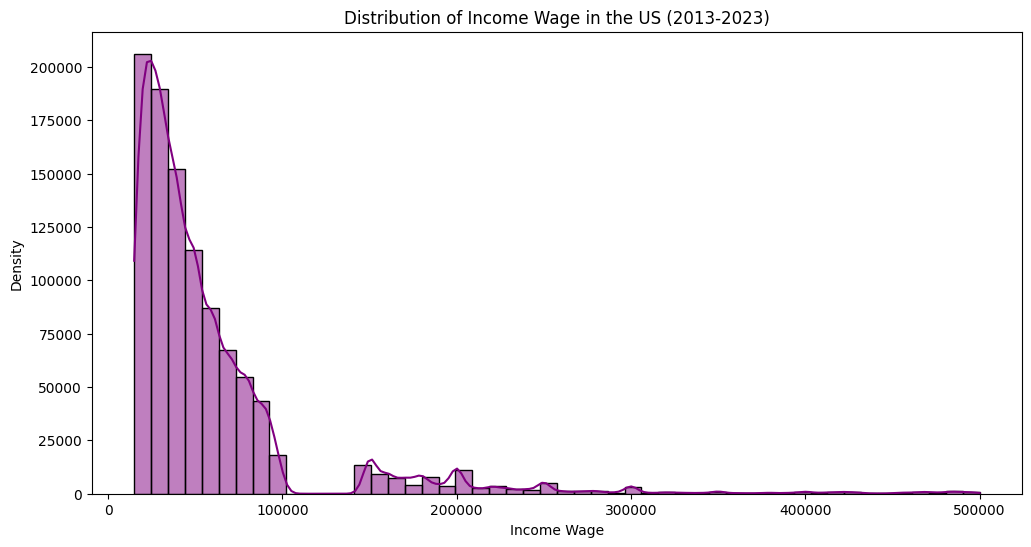

In [16]:
# Distribution of INCWAGE
plt.figure(figsize=(12, 6))
sns.histplot(df['INCWAGE'], bins=50, color='purple', kde=True)
plt.title('Distribution of Income Wage in the US (2013-2023)')
plt.xlabel('Income Wage')
plt.ylabel('Density')
plt.show()

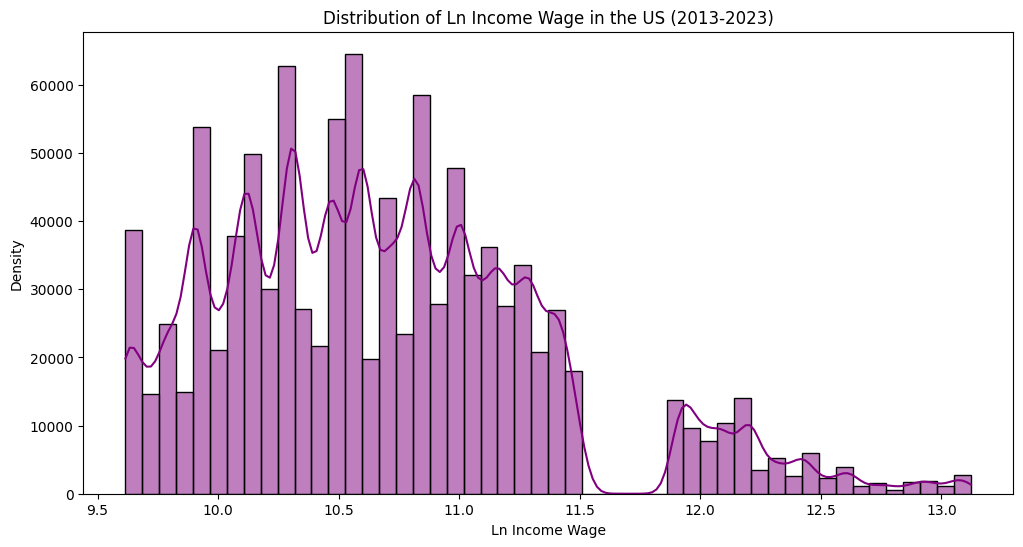

In [17]:
# Distribution of sqrt(INCWAGE)
plt.figure(figsize=(12, 6))
sns.histplot(np.log(df['INCWAGE']), bins=50, color='purple', kde=True)
plt.title('Distribution of Ln Income Wage in the US (2013-2023)')
plt.xlabel('Ln Income Wage')
plt.ylabel('Density')
plt.show()

C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\2573003715.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=column, y='count', data=plot_data, ax=axs[i//3, i%3], palette='RdPu')
C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\2573003715.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=column, y='count', data=plot_data, ax=axs[i//3, i%3], palette='RdPu')
C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\2573003715.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=column, y='count', data=plot_data, ax=axs[i//3, i%3], palet

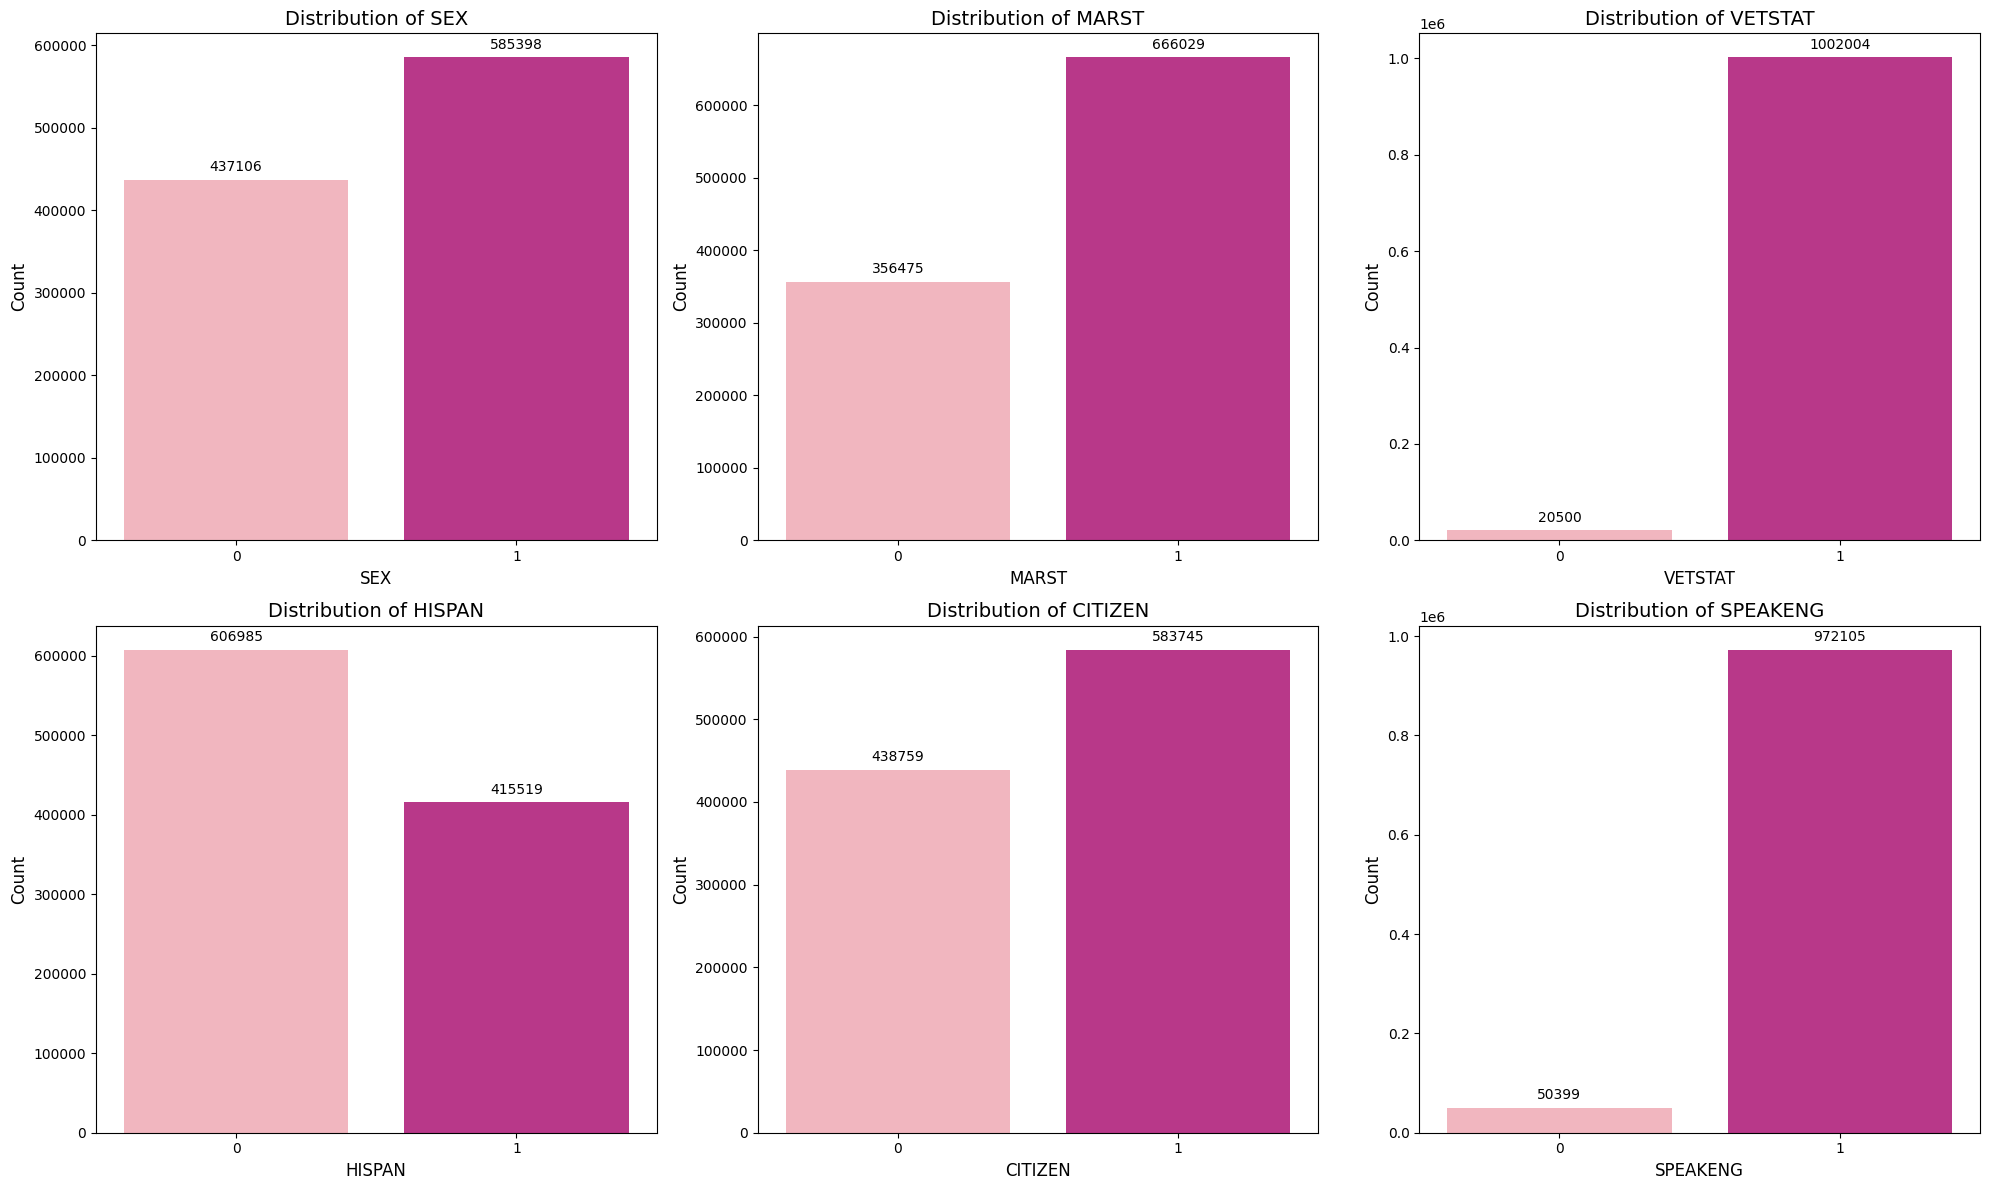

In [18]:
# Define the columns to plot
columns_to_plot = ['SEX', 'MARST', 'VETSTAT', 'HISPAN', 'CITIZEN', 'SPEAKENG']

# Create a figure with 5 subplots (2 rows, 3 columns)
fig, axs = plt.subplots(2, 3, figsize=(20, 12))

# Loop through the columns and create bar plots
for i, column in enumerate(columns_to_plot):
    # Group data by the column and calculate the count of each category
    plot_data = df[column].value_counts().reset_index()
    plot_data.columns = [column, 'count']
    
    # Create bar plot
    sns.barplot(x=column, y='count', data=plot_data, ax=axs[i//3, i%3], palette='RdPu')
    
    # Show numbers on top of each bar
    for p in axs[i//3, i%3].patches:
        axs[i//3, i%3].annotate(format(p.get_height(), '.0f'), 
                                (p.get_x() + p.get_width() / 2., p.get_height()), 
                                ha = 'center', va = 'center', 
                                xytext = (0, 9), 
                                textcoords = 'offset points')
    
    # Set title and labels
    axs[i//3, i%3].set_title(f'Distribution of {column}', fontsize=14)
    axs[i//3, i%3].set_xlabel(column, fontsize=12)
    axs[i//3, i%3].set_ylabel('Count', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the combined plots
plt.show()

C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\2313969467.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hispan_stats['HISPAN'], y=hispan_stats['median_incwage'], ax=axs[0], palette='RdPu')
C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\2313969467.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hispan_stats['HISPAN'], y=hispan_stats['mean_incwage'], ax=axs[1], palette='RdPu')


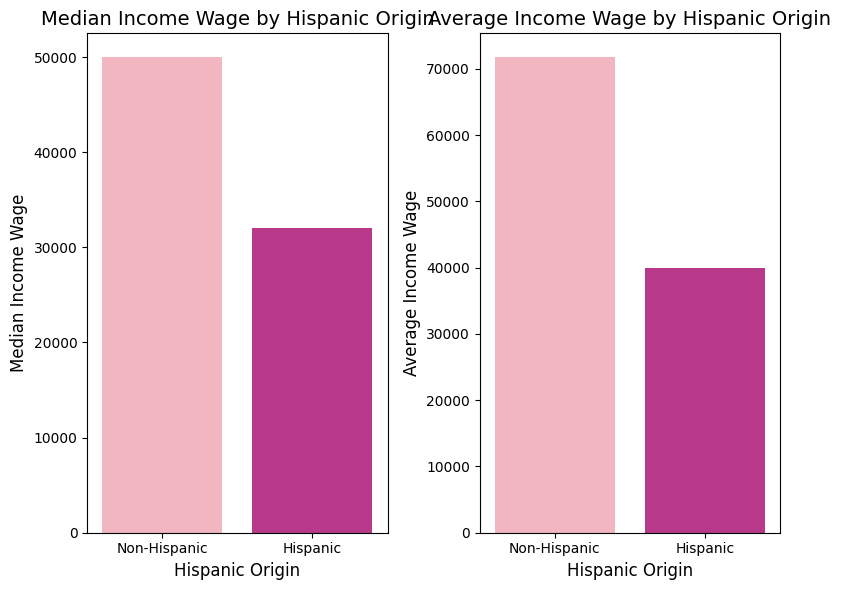

In [19]:
# Group data by gender and calculate median and mean income wage
hispan_stats = df.groupby('HISPAN').agg(
    median_incwage=('INCWAGE', 'median'), 
    mean_incwage=('INCWAGE', 'mean')
).reset_index()

# Rename gender categories
hispan_stats['HISPAN'] = hispan_stats['HISPAN'].map({0: 'Non-Hispanic', 1: 'Hispanic'})

# Create a combined figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Bar chart for Median Income Wage by Gender
sns.barplot(x=hispan_stats['HISPAN'], y=hispan_stats['median_incwage'], ax=axs[0], palette='RdPu')
axs[0].set_title('Median Income Wage by Hispanic Origin', fontsize=14)
axs[0].set_xlabel('Hispanic Origin', fontsize=12)
axs[0].set_ylabel('Median Income Wage', fontsize=12)

# Bar chart for Average Income Wage by Gender
sns.barplot(x=hispan_stats['HISPAN'], y=hispan_stats['mean_incwage'], ax=axs[1], palette='RdPu')
axs[1].set_title('Average Income Wage by Hispanic Origin', fontsize=14)
axs[1].set_xlabel('Hispanic Origin', fontsize=12)
axs[1].set_ylabel('Average Income Wage', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the combined plots
plt.show()

C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\3187916324.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_stats['SEX'], y=gender_stats['median_incwage'], ax=axs[0], palette='RdPu')
C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\3187916324.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_stats['SEX'], y=gender_stats['mean_incwage'], ax=axs[1], palette='RdPu')


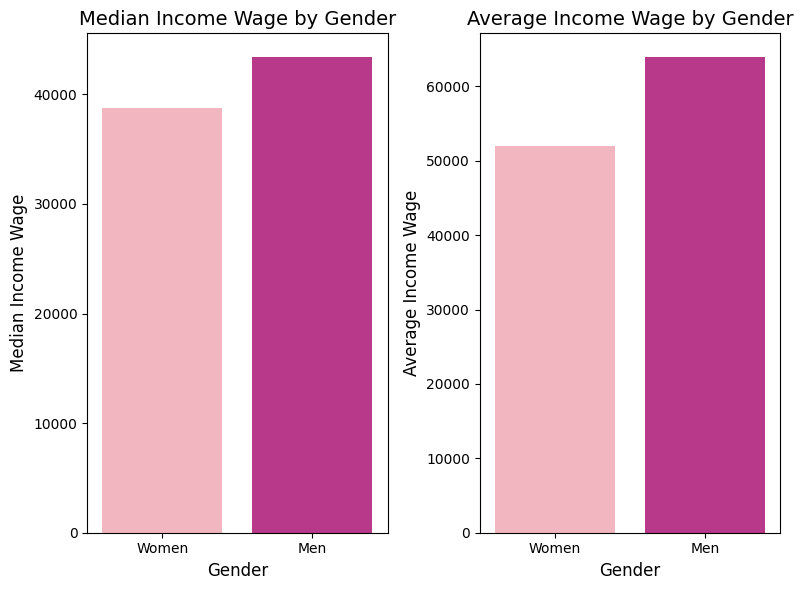

In [20]:
# Group data by gender and calculate median and mean income wage
gender_stats = df.groupby('SEX').agg(
    median_incwage=('INCWAGE', 'median'), 
    mean_incwage=('INCWAGE', 'mean')
).reset_index()

# Rename gender categories
gender_stats['SEX'] = gender_stats['SEX'].map({0: 'Women', 1: 'Men'})

# Create a combined figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Bar chart for Median Income Wage by Gender
sns.barplot(x=gender_stats['SEX'], y=gender_stats['median_incwage'], ax=axs[0], palette='RdPu')
axs[0].set_title('Median Income Wage by Gender', fontsize=14)
axs[0].set_xlabel('Gender', fontsize=12)
axs[0].set_ylabel('Median Income Wage', fontsize=12)

# Bar chart for Average Income Wage by Gender
sns.barplot(x=gender_stats['SEX'], y=gender_stats['mean_incwage'], ax=axs[1], palette='RdPu')
axs[1].set_title('Average Income Wage by Gender', fontsize=14)
axs[1].set_xlabel('Gender', fontsize=12)
axs[1].set_ylabel('Average Income Wage', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the combined plots
plt.show()

C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\410231514.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=citizen_stats['CITIZEN'], y=citizen_stats['median_incwage'], ax=axs[0], palette='RdPu')
C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\410231514.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=citizen_stats['CITIZEN'], y=citizen_stats['mean_incwage'], ax=axs[1], palette='RdPu')


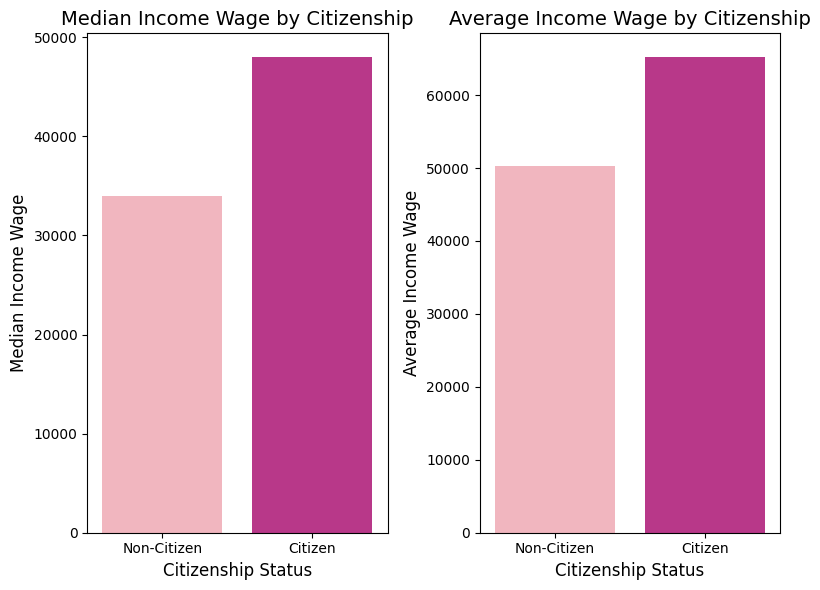

In [21]:
# Group data by CITIZEN and calculate median and mean income wage
citizen_stats = df.groupby('CITIZEN').agg(
    median_incwage=('INCWAGE', 'median'), 
    mean_incwage=('INCWAGE', 'mean')
).reset_index()

# Rename CITIZEN categories
citizen_stats['CITIZEN'] = citizen_stats['CITIZEN'].map({0: 'Non-Citizen', 1: 'Citizen'})

# Create a combined figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Bar chart for Median Income Wage by Citizenship
sns.barplot(x=citizen_stats['CITIZEN'], y=citizen_stats['median_incwage'], ax=axs[0], palette='RdPu')
axs[0].set_title('Median Income Wage by Citizenship', fontsize=14)
axs[0].set_xlabel('Citizenship Status', fontsize=12)
axs[0].set_ylabel('Median Income Wage', fontsize=12)

# Bar chart for Average Income Wage by Citizenship
sns.barplot(x=citizen_stats['CITIZEN'], y=citizen_stats['mean_incwage'], ax=axs[1], palette='RdPu')
axs[1].set_title('Average Income Wage by Citizenship', fontsize=14)
axs[1].set_xlabel('Citizenship Status', fontsize=12)
axs[1].set_ylabel('Average Income Wage', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the combined plots
plt.show()

C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\1099065245.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eng_stats['SPEAKENG'], y=eng_stats['median_incwage'], ax=axs[0], palette='RdPu')
C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\1099065245.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eng_stats['SPEAKENG'], y=eng_stats['mean_incwage'], ax=axs[1], palette='RdPu')


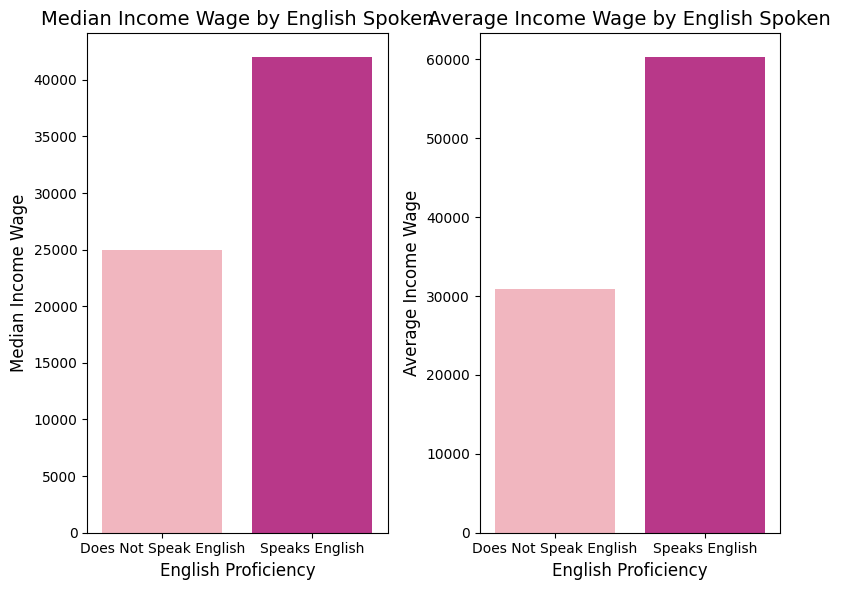

In [22]:
# Group data by English spoken and calculate median and mean income wage
eng_stats = df.groupby('SPEAKENG').agg(
    median_incwage=('INCWAGE', 'median'), 
    mean_incwage=('INCWAGE', 'mean')
).reset_index()

# Rename English spoken categories
eng_stats['SPEAKENG'] = eng_stats['SPEAKENG'].map({0: 'Does Not Speak English', 1: 'Speaks English'})

# Create a combined figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Bar chart for Median Income Wage by English Spoken
sns.barplot(x=eng_stats['SPEAKENG'], y=eng_stats['median_incwage'], ax=axs[0], palette='RdPu')
axs[0].set_title('Median Income Wage by English Spoken', fontsize=14)
axs[0].set_xlabel('English Proficiency', fontsize=12)
axs[0].set_ylabel('Median Income Wage', fontsize=12)

# Bar chart for Average Income Wage by English Spoken
sns.barplot(x=eng_stats['SPEAKENG'], y=eng_stats['mean_incwage'], ax=axs[1], palette='RdPu')
axs[1].set_title('Average Income Wage by English Spoken', fontsize=14)
axs[1].set_xlabel('English Proficiency', fontsize=12)
axs[1].set_ylabel('Average Income Wage', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the combined plots
plt.show()


C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\276993224.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=veteran_stats['VETSTAT'], y=veteran_stats['median_incwage'], ax=axs[0], palette='RdPu')
C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\276993224.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=veteran_stats['VETSTAT'], y=veteran_stats['mean_incwage'], ax=axs[1], palette='RdPu')


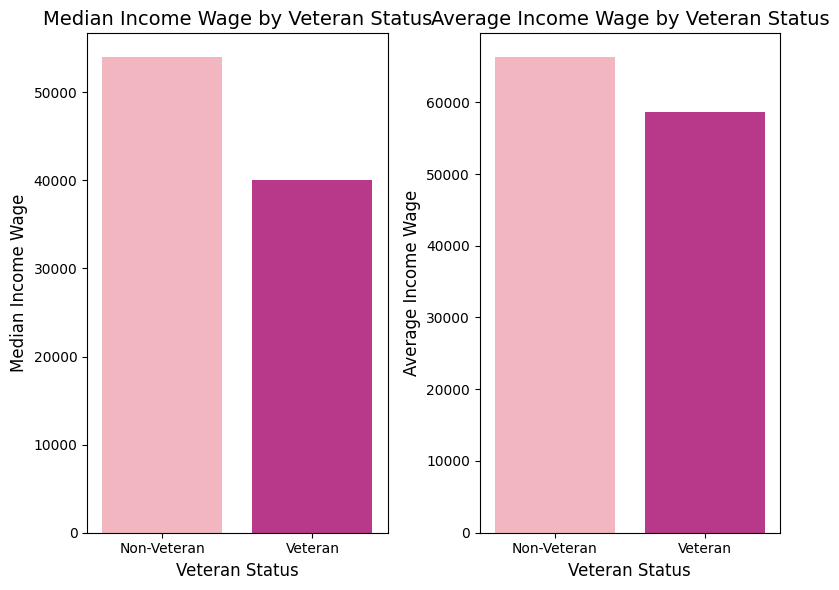

In [23]:
# Group data by VETSTAT status and calculate median and mean income wage
veteran_stats = df.groupby('VETSTAT').agg(
    median_incwage=('INCWAGE', 'median'), 
    mean_incwage=('INCWAGE', 'mean')
).reset_index()

# Rename VETSTAT status categories
veteran_stats['VETSTAT'] = veteran_stats['VETSTAT'].map({0: 'Non-Veteran', 1: 'Veteran'})

# Create a combined figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Bar chart for Median Income Wage by Veteran Status
sns.barplot(x=veteran_stats['VETSTAT'], y=veteran_stats['median_incwage'], ax=axs[0], palette='RdPu')
axs[0].set_title('Median Income Wage by Veteran Status', fontsize=14)
axs[0].set_xlabel('Veteran Status', fontsize=12)
axs[0].set_ylabel('Median Income Wage', fontsize=12)

# Bar chart for Average Income Wage by Veteran Status
sns.barplot(x=veteran_stats['VETSTAT'], y=veteran_stats['mean_incwage'], ax=axs[1], palette='RdPu')
axs[1].set_title('Average Income Wage by Veteran Status', fontsize=14)
axs[1].set_xlabel('Veteran Status', fontsize=12)
axs[1].set_ylabel('Average Income Wage', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the combined plots
plt.show()


C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\2385771557.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=marriage_stats['MARST'], y=marriage_stats['median_incwage'], ax=axs[0], palette='RdPu')
C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\2385771557.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=marriage_stats['MARST'], y=marriage_stats['mean_incwage'], ax=axs[1], palette='RdPu')


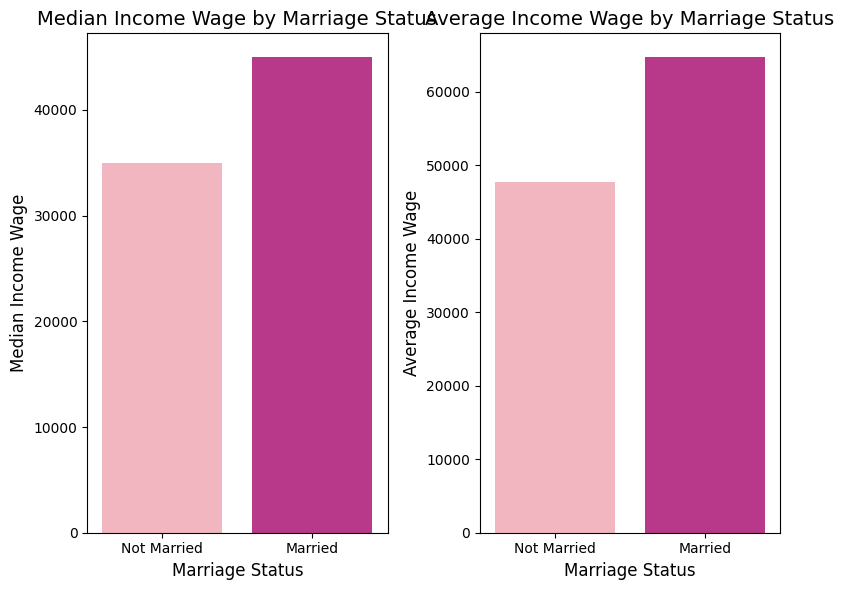

In [24]:
# Group data by marriage status and calculate median and mean income wage
marriage_stats = df.groupby('MARST').agg(
    median_incwage=('INCWAGE', 'median'), 
    mean_incwage=('INCWAGE', 'mean')
).reset_index()

# Rename marriage status categories
marriage_stats['MARST'] = marriage_stats['MARST'].map({0: 'Not Married', 1: 'Married'})

# Create a combined figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Bar chart for Median Income Wage by Marriage Status
sns.barplot(x=marriage_stats['MARST'], y=marriage_stats['median_incwage'], ax=axs[0], palette='RdPu')
axs[0].set_title('Median Income Wage by Marriage Status', fontsize=14)
axs[0].set_xlabel('Marriage Status', fontsize=12)
axs[0].set_ylabel('Median Income Wage', fontsize=12)

# Bar chart for Average Income Wage by Marriage Status
sns.barplot(x=marriage_stats['MARST'], y=marriage_stats['mean_incwage'], ax=axs[1], palette='RdPu')
axs[1].set_title('Average Income Wage by Marriage Status', fontsize=14)
axs[1].set_xlabel('Marriage Status', fontsize=12)
axs[1].set_ylabel('Average Income Wage', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the combined plots
plt.show()

C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\4245090052.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RACE', y='INCWAGE', data=race_stats, palette='RdPu')


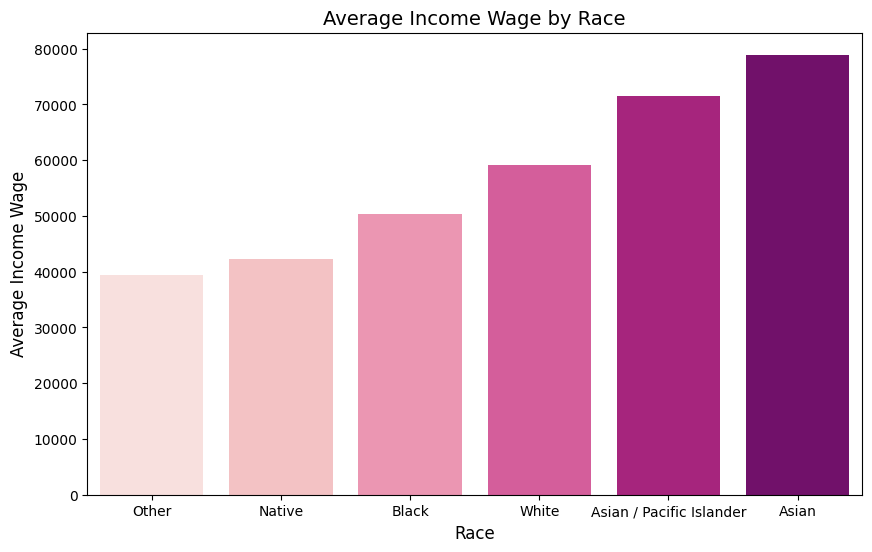

In [25]:
# Group by RACE and calculate mean income wage
race_stats = df.groupby('RACE')['INCWAGE'].mean().reset_index()

# Sort values from high to low
race_stats = race_stats.sort_values(by='INCWAGE', ascending=True)

# Create bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='RACE', y='INCWAGE', data=race_stats, palette='RdPu')

# Labels and title
plt.xlabel('Race', fontsize=12)
plt.ylabel('Average Income Wage', fontsize=12)
plt.title('Average Income Wage by Race', fontsize=14)

# Show plot
plt.show()

C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\3322903840.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='EDUC', y='INCWAGE', data=educ_stats, palette='RdPu')


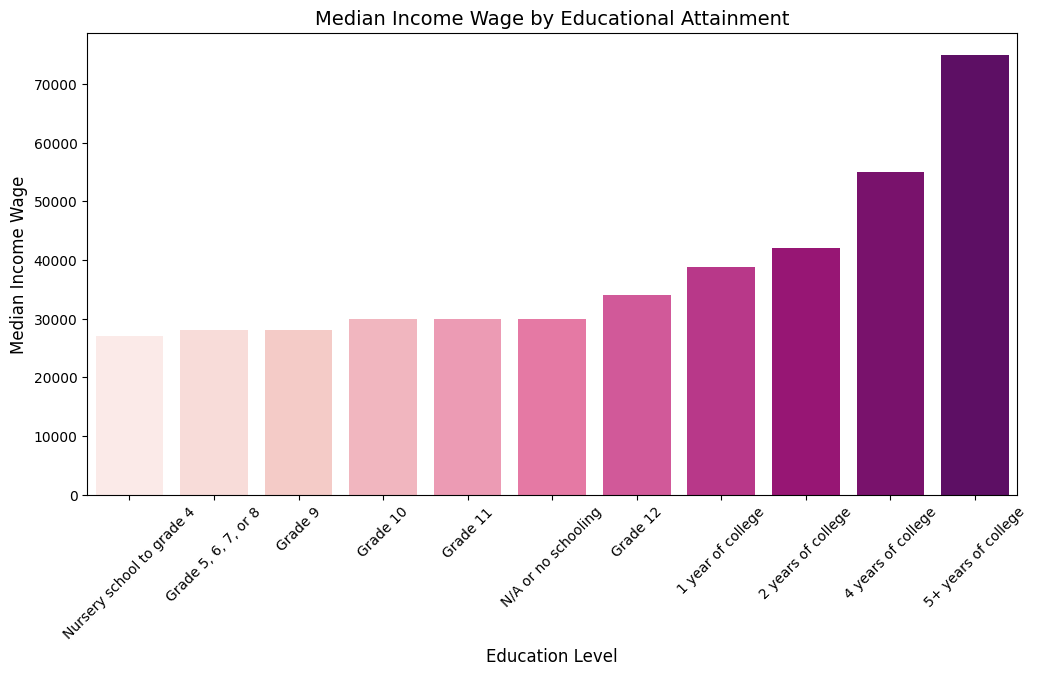

In [26]:
# Group data by education level and calculate median income wage
educ_stats = df.groupby('EDUC')['INCWAGE'].median().reset_index()

# Sort values from highest to lowest
educ_stats = educ_stats.sort_values(by='INCWAGE', ascending=True)

# Create bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='EDUC', y='INCWAGE', data=educ_stats, palette='RdPu')

# Customize labels and title
plt.title('Median Income Wage by Educational Attainment', fontsize=14)
plt.xlabel('Education Level', fontsize=12)
plt.ylabel('Median Income Wage', fontsize=12)

# Rotate x labels for readability
plt.xticks(rotation=45)

# Show plot
plt.show()

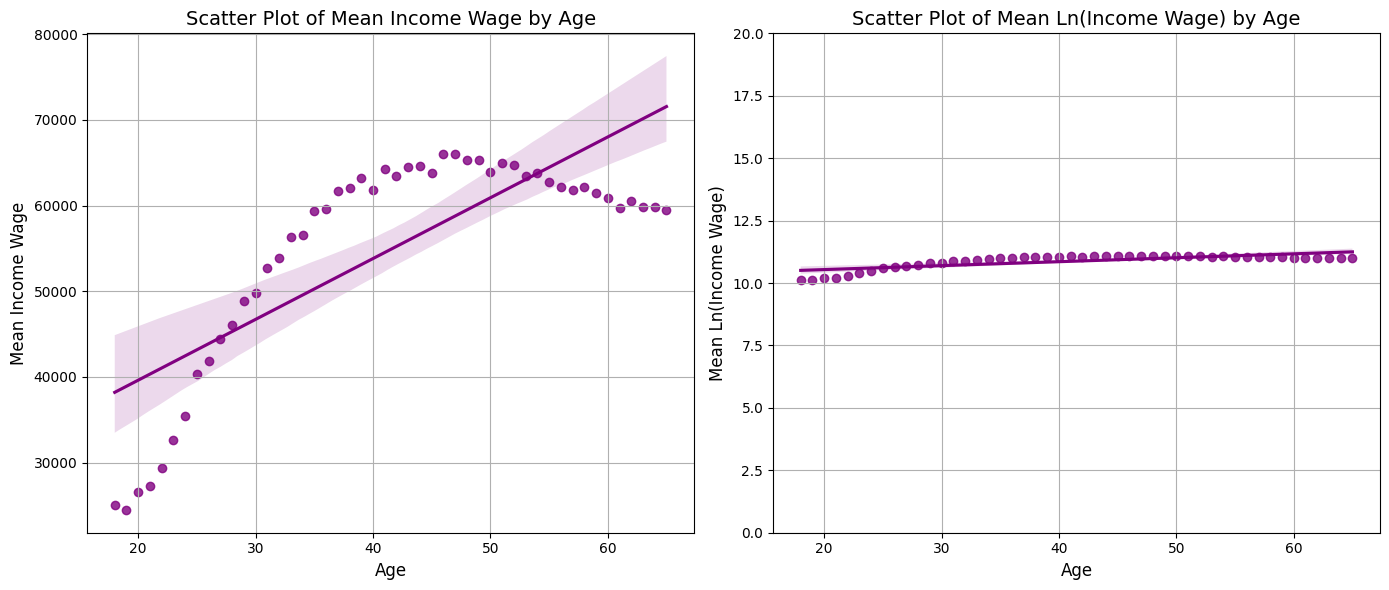

In [40]:
# Group by AGE and calculate mean income wage
age_stats = df.groupby('AGE', as_index=False)['INCWAGE'].mean()

# Calculate the natural sqrt of INCWAGE and add it to the dataset
age_stats['ln_incwage'] = np.log(age_stats['INCWAGE'])

# Create the figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# First scatter plot: Mean Income Wage by Age
sns.regplot(x='AGE', y='INCWAGE', data=age_stats, ax=axs[0], color='purple')
axs[0].set_xlabel('Age', fontsize=12)
axs[0].set_ylabel('Mean Income Wage', fontsize=12)
axs[0].set_title('Scatter Plot of Mean Income Wage by Age', fontsize=14)
axs[0].grid()

# Second scatter plot: Mean ln(Income Wage) by Age
sns.regplot(x='AGE', y='ln_incwage', data=age_stats, ax=axs[1], color='purple')
axs[1].set_xlabel('Age', fontsize=12)
axs[1].set_ylabel('Mean Ln(Income Wage)', fontsize=12)
axs[1].set_title('Scatter Plot of Mean Ln(Income Wage) by Age', fontsize=14)
axs[1].set_ylim(0, 20)
axs[1].grid()

# Adjust layout
plt.tight_layout()

# Show the combined plots
plt.show()


C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\4072217229.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='INCWAGE', y='DEGFIELD1', data=top_10_degfield, palette='RdPu_r')


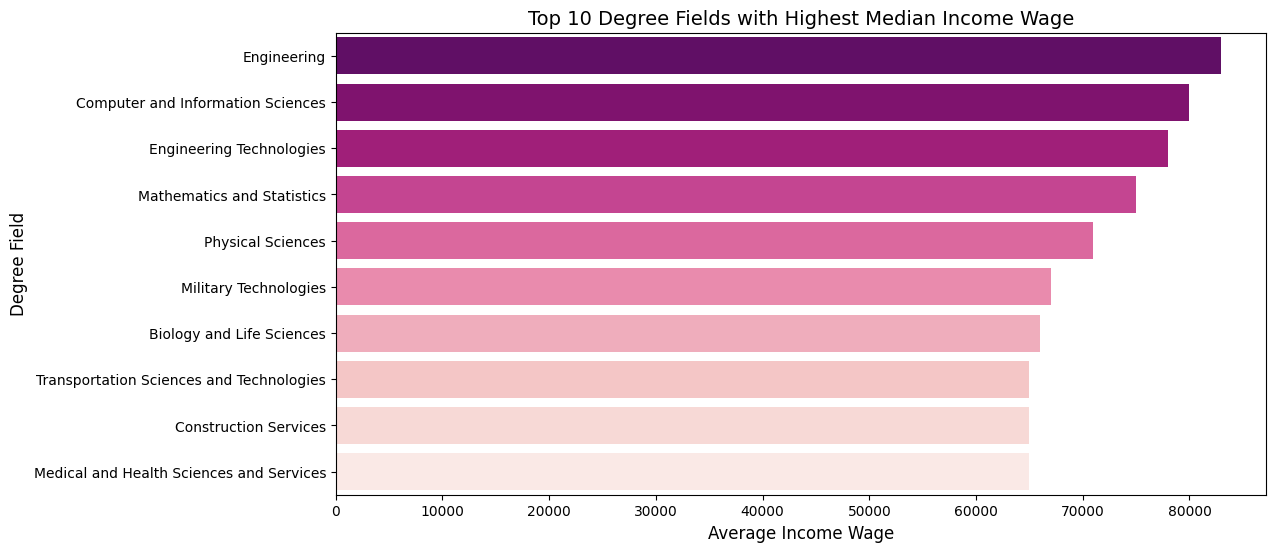

In [28]:
# Group by DEGFIELD1 and calculate mean income wage
degfield_stats = df.groupby('DEGFIELD1')['INCWAGE'].median().reset_index()

# Sort values from high to low and select top 10
top_10_degfield = degfield_stats.sort_values(by='INCWAGE', ascending=False).head(10)

# Create bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='INCWAGE', y='DEGFIELD1', data=top_10_degfield, palette='RdPu_r')

# Customize labels and title
plt.title('Top 10 Degree Fields with Highest Median Income Wage', fontsize=14)
plt.xlabel('Average Income Wage', fontsize=12)
plt.ylabel('Degree Field', fontsize=12)

# Show plot
plt.show()

C:\Users\lengu\AppData\Local\Temp\ipykernel_14848\4055275137.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='INCWAGE', y='OCC', data=top_10_degfield, palette='RdPu_r')


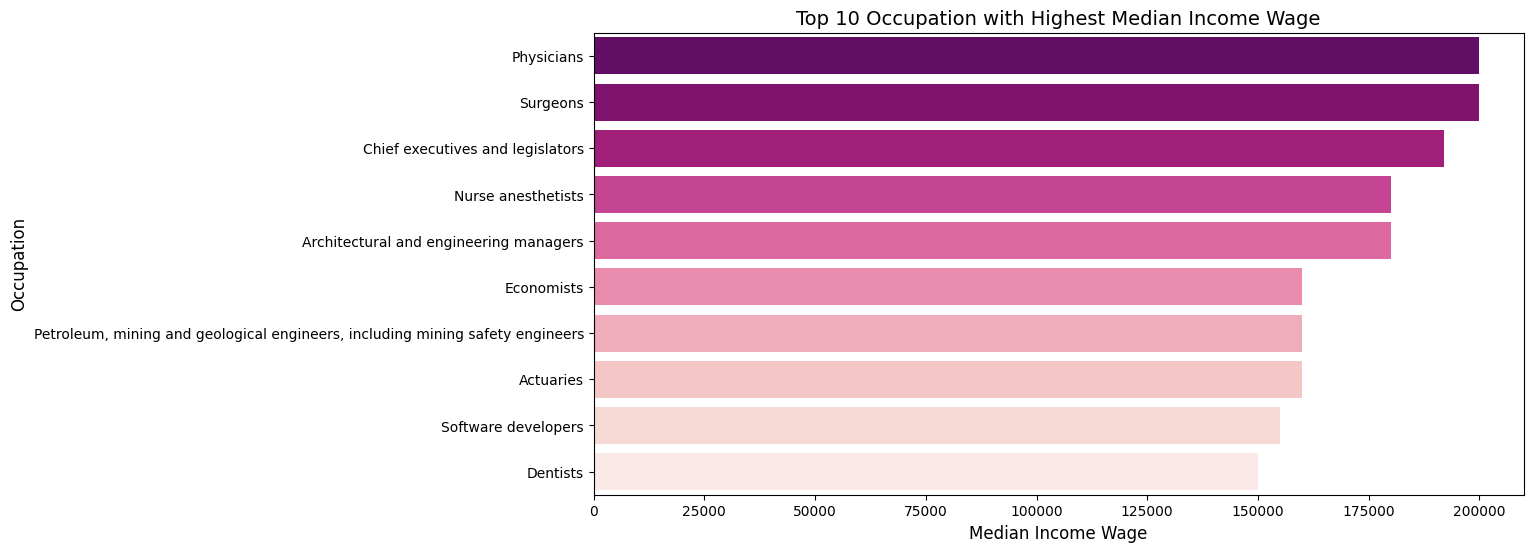

In [29]:
# Group by DEGFIELD1 and calculate mean income wage
degfield_stats = df.groupby('OCC')['INCWAGE'].median().reset_index()

# Sort values from high to low and select top 10
top_10_degfield = degfield_stats.sort_values(by='INCWAGE', ascending=False).head(10)

# Create bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='INCWAGE', y='OCC', data=top_10_degfield, palette='RdPu_r')

# Customize labels and title
plt.title('Top 10 Occupation with Highest Median Income Wage', fontsize=14)
plt.xlabel('Median Income Wage', fontsize=12)
plt.ylabel('Occupation', fontsize=12)

# Show plot
plt.show()

# Feature Engineering

In [6]:
# Display all columns with object data type
object_columns = df.select_dtypes(include=['object']).columns
print(object_columns)

Index(['EDUC', 'DEGFIELD1', 'DEGFIELD2', 'OCC', 'IND', 'RACE', 'WORKSTATE'], dtype='object')


In [7]:
df['LN_INCWAGE'] = np.log(df['INCWAGE'])

# Define the feature matrix X and the target vector y
X = df.drop(columns=['INCWAGE', 'LN_INCWAGE', 'EDUCYEARS'] + list(object_columns))
y = df['LN_INCWAGE']

df[object_columns] = df[object_columns].astype('category')
df[object_columns].dtypes

EDUC         category
DEGFIELD1    category
DEGFIELD2    category
OCC          category
IND          category
RACE         category
WORKSTATE    category
dtype: object

In [8]:
# Perform target encoding with smoothing
def target_encode_with_smoothing(column, smoothing=1.0):
    mean_encoded = df.groupby(column)['LN_INCWAGE'].mean()
    global_mean = df['LN_INCWAGE'].mean()
    # Smoothing formula: Weighted average between global mean and category mean
    count = df[column].value_counts()
    smoothed_values = (count * mean_encoded + smoothing * global_mean) / (count + smoothing)
    return df[column].map(smoothed_values).astype('float64')

# Apply target encoding with smoothing
X['OCC'] = target_encode_with_smoothing('OCC')
X['IND'] = target_encode_with_smoothing('IND')
X['EDUC'] = target_encode_with_smoothing('EDUC')
X['DEGFIELD1'] = target_encode_with_smoothing('DEGFIELD1')
X['DEGFIELD2'] = target_encode_with_smoothing('DEGFIELD2')
X['RACE'] = target_encode_with_smoothing('RACE')
X['WORKSTATE'] = target_encode_with_smoothing('WORKSTATE')

len(X.columns)

C:\Users\lengu\AppData\Local\Temp\ipykernel_2516\851097423.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_encoded = df.groupby(column)['LN_INCWAGE'].mean()
C:\Users\lengu\AppData\Local\Temp\ipykernel_2516\851097423.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_encoded = df.groupby(column)['LN_INCWAGE'].mean()
C:\Users\lengu\AppData\Local\Temp\ipykernel_2516\851097423.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silen

14

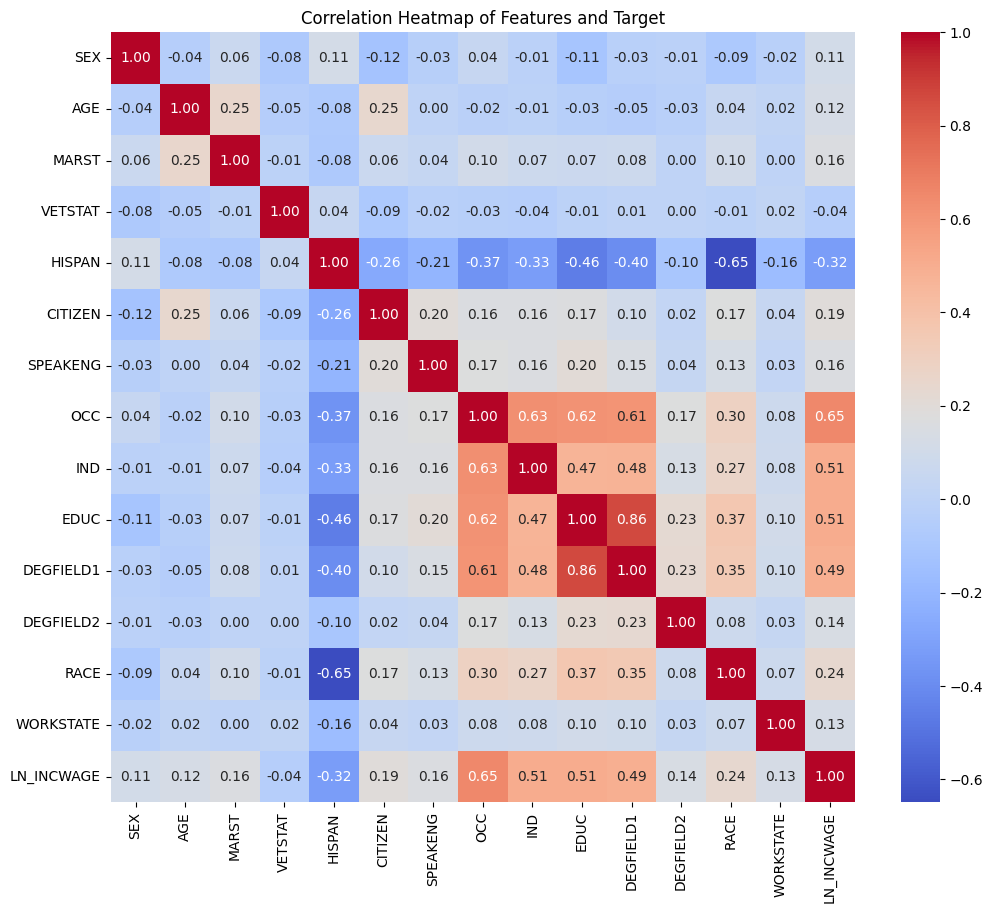

In [9]:
# Combine X and y into a single DataFrame for visualization
data = X.copy()
data['LN_INCWAGE'] = y

# Create a correlation matrix
corr_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features and Target')
plt.show()

# Regressors

In [ ]:
# Define KFold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Hyperparameter tuning for Lasso
lasso_param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]
}
lasso_grid_search = GridSearchCV(Lasso(),
                                 lasso_param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)

# Hyperparameter tuning for XGBoost (Expanded Grid)
xgb_param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 12],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.4, 0.6, 0.8]
}
xgb_grid_search = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42),
                               xgb_param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)

In [11]:
# Scale X for Lasso
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# # Define models with default parameters
ols = LinearRegression()
lasso = Lasso(random_state=42)
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

In [ ]:
lasso_grid_search.fit(X_scaled, y)
best_lasso = lasso_grid_search.best_estimator_
# Best tuning parameters for Lasso
print("\nBest Lasso Parameters:")
print(lasso_grid_search.best_params_)

xgb_grid_search.fit(X, y) # This process is time and space expensive. Use the result below if you don't want to run this line
best_xgb = xgb_grid_search.best_estimator_
# Best tuning parameters for XGBoost
print("\nBest XGBoost Parameters:")
print(xgb_grid_search.best_params_)


Best Lasso Parameters:
{'alpha': 0.0001}

Best XGBoost Parameters:
{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'n_estimators': 200}


Best params are:

Lasso:
alpha=0.001

XGBoost:
learning_rate=0.1, n_estimators=200, max_depth=10, subsample=1.0, colsample_bytree=0.6,

# Evaluation

In [15]:
# Define KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Function to evaluate models
def evaluate(model, X, y, model_name):
    rmse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error').mean() * -1
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2').mean()

    print(f"\n{model_name} Performance (10-Fold CV):")
    print(f"RMSE: {rmse_scores:.4f}")
    print(f"R² Score: {r2_scores:.4f}")

In [16]:
# # Evaluate best models before tuning
print("\nEvaluating Models Before Hyperparameter Tuning:")
evaluate(ols, X, y, "OLS")
evaluate(lasso, X_scaled, y, "Lasso")
evaluate(xgb, X, y, "XGBoost")


Evaluating Models Before Hyperparameter Tuning:

OLS Performance (10-Fold CV):
RMSE: 0.4850
R² Score: 0.4991

Lasso Performance (10-Fold CV):
RMSE: 0.6853
R² Score: -0.0000

XGBoost Performance (10-Fold CV):
RMSE: 0.4563
R² Score: 0.5566


In [17]:
# Evaluate best models before tuning
print("\nEvaluating Models After Hyperparameter Tuning:")
evaluate(best_lasso, X_scaled, y, "Lasso")
evaluate(best_xgb, X, y, "XGBoost")


Evaluating Models After Hyperparameter Tuning:

Lasso Performance (10-Fold CV):
RMSE: 0.4850
R² Score: 0.4991

XGBoost Performance (10-Fold CV):
RMSE: 0.4516
R² Score: 0.5657
